# Title Generator using Deep Learning

In this project, we are trying to predict the Title for the YouTube Video.

In short, the model is trained to predict the next word in a sequence of words given a preceding sequence.

The model employs a Long Short-Term Memory (LSTM) architecture to learn the sequential patterns in the text data and generate coherent titles.

The process involves data collection, preprocessing, sequence generation, model training, and testing. Key steps include tokenization, padding sequences, and defining the LSTM model.

The resulting model is capable of generating new titles based on input seed texts, demonstrating its potential application in various natural language processing tasks.

Overall, the article provides a comprehensive overview of building and testing a title generator model using machine learning approaches.








### setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import string
import numpy as np
import json

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku

import tensorflow as tf
tf.random.set_seed(2)
from numpy.random import seed
seed(1)

#load all the datasets
df1 = pd.read_csv('/content/drive/MyDrive/dataset/USvideos.csv')
df2 = pd.read_csv('/content/drive/MyDrive/dataset/CAvideos.csv')
df3 = pd.read_csv('/content/drive/MyDrive/dataset/GBvideos.csv')

#load the datasets containing the category names
category_data1 = json.load(open('/content/drive/MyDrive/dataset/US_category_id.json'))
category_data2 = json.load(open('/content/drive/MyDrive/dataset/CA_category_id.json'))
category_data3 = json.load(open('/content/drive/MyDrive/dataset/GB_category_id.json'))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings(action="ignore")

In [ ]:
!pip install -q langdetect

In [ ]:
from langdetect import detect, LangDetectException

### Data Exploration

In [ ]:
print(df1.shape)
print(df2.shape)
print(df3.shape)

In [ ]:
print(df1.isna().sum())
print(df2.isna().sum())
print(df3.isna().sum())

Only the `description` column in the dataset has missing instances.

Since this column is not used for modelling, we don't have to worry about missing data in this column.

In [ ]:
# add country in the data

df1['country'] = 'USA'
df2['country'] = 'CA'
df3['country'] = 'BR'

In [ ]:
# combine dataframe for analysis

combined_df = pd.concat([df1, df2, df3]).reset_index(drop=True)

In [ ]:
# see if there are duplicates
combined_df[combined_df.duplicated()]

In [ ]:
combined_df[combined_df.video_id=='9qTJR0575Ek']

From the looks, the data is generated based on the trending videos.

Even though the `video_id` is duplicated, the trending date is different, so is the likes-dislikes count.

So, we will keep only the latest record to consider the changes in the video details.

In [ ]:
# first sort by id and trending date
combined_df.sort_values(['video_id', 'trending_date'], ascending=True, inplace=True)

In [ ]:
# drop and keep latest record

combined_df.drop_duplicates('video_id', keep="last", inplace=True)

In [ ]:
plt.figure(figsize=(5, 3))
sns.countplot(data=combined_df, x='country')

In [ ]:
def category_extractor(data):
    i_d = [data['items'][i]['id'] for i in range(len(data['items']))]
    title = [data['items'][i]['snippet']["title"] for i in range(len(data['items']))]
    i_d = list(map(int, i_d))
    category = zip(i_d, title)
    category = dict(category)
    return category

In [ ]:
#create a new category column by mapping the category names to their id
df1['category_title'] = df1['category_id'].map(category_extractor(category_data1))
df2['category_title'] = df2['category_id'].map(category_extractor(category_data2))
df3['category_title'] = df3['category_id'].map(category_extractor(category_data3))

#join the dataframes
combined_df = pd.concat([df1, df2, df3], ignore_index=True)

In [ ]:
# first sort by id and trending date
combined_df.sort_values(['video_id', 'trending_date'], ascending=True, inplace=True)

# drop and keep latest record
combined_df.drop_duplicates('video_id', keep="last", inplace=True)

In [ ]:
combined_df.head()

### Problem Descritption Poster

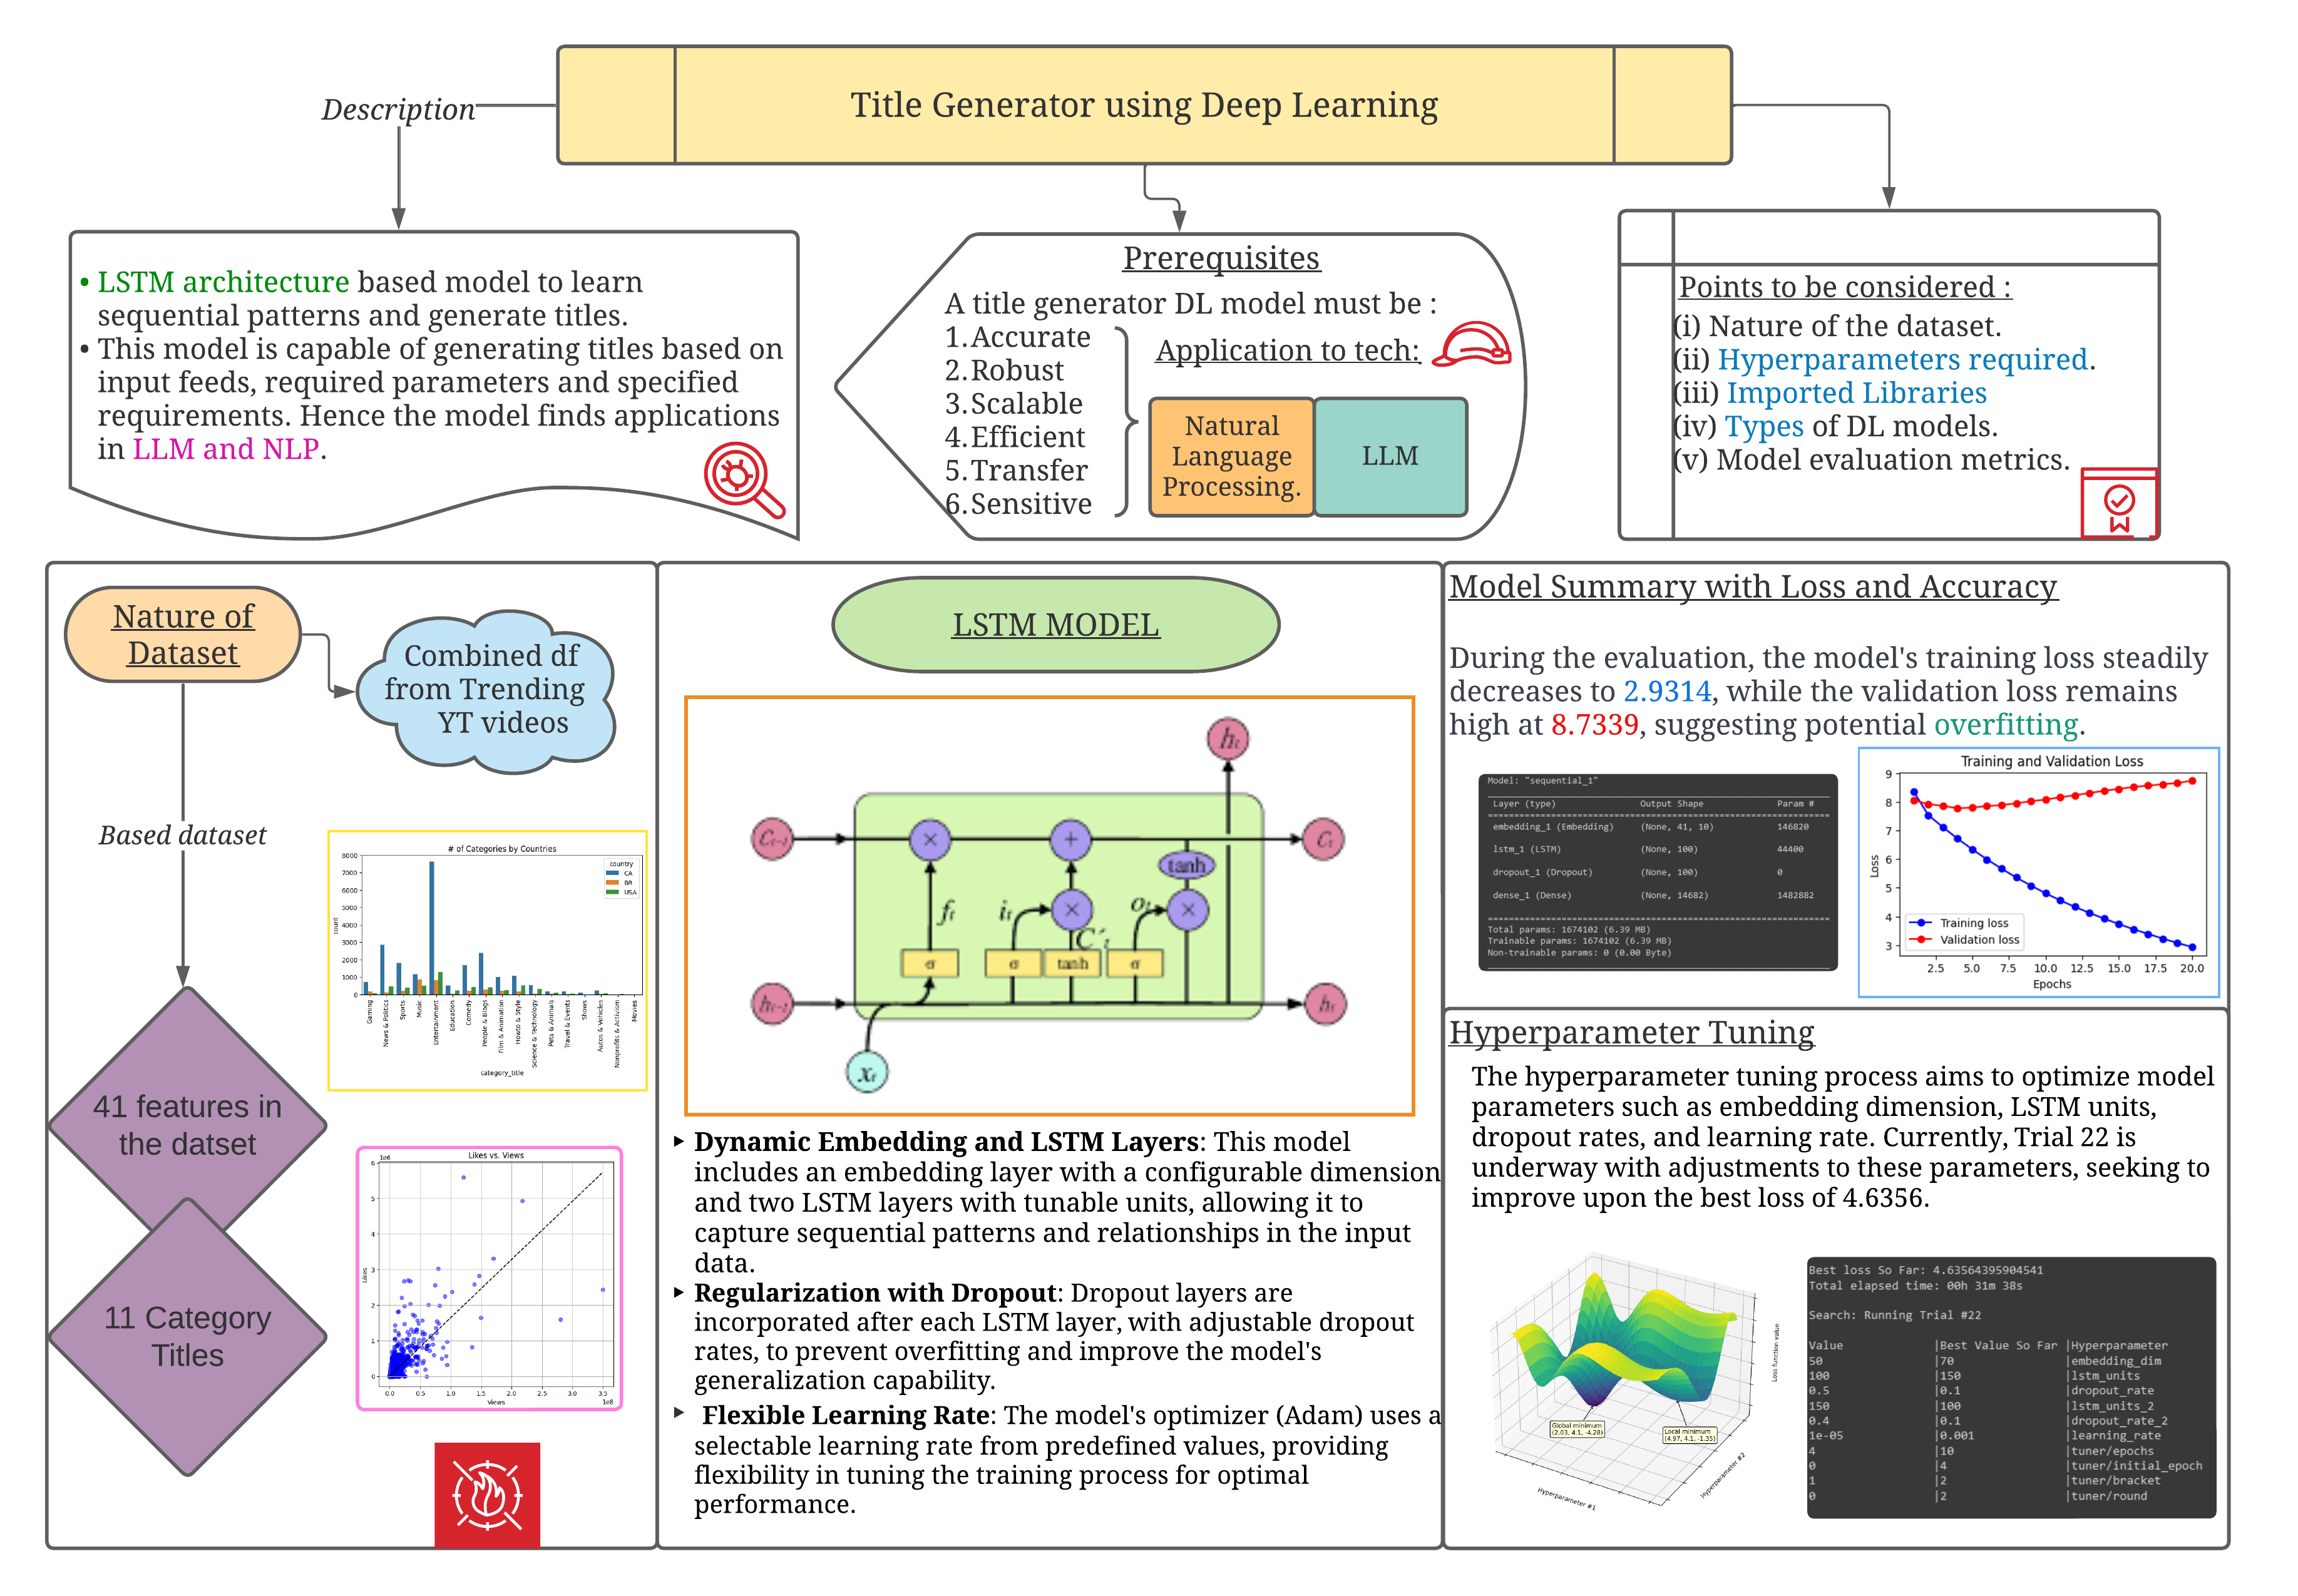

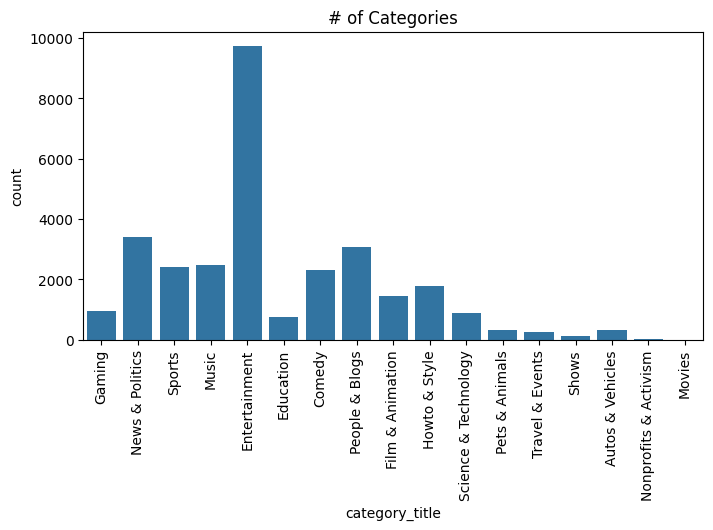

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(data=combined_df, x='category_title')
plt.xticks(rotation=90)
plt.title("# of Categories")
plt.show()

Since `category_title` "**Entertainment**" has the highest number of videos in the dataset, we will train out model only for this caterogy.

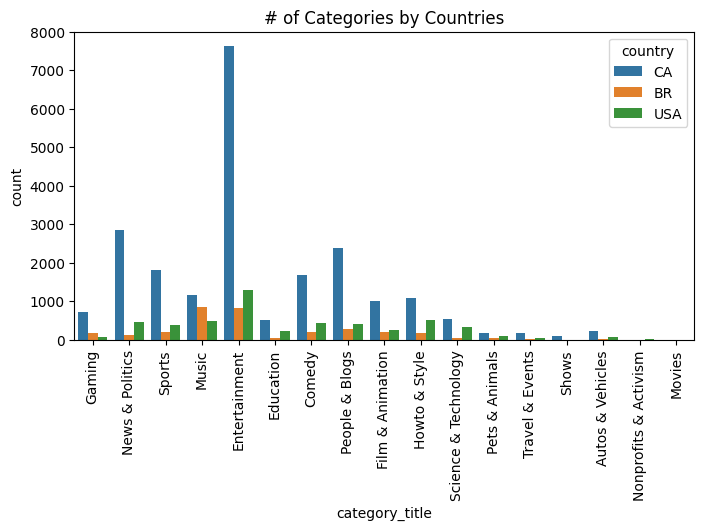

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(data=combined_df, x='category_title', hue='country')
plt.xticks(rotation=90)
plt.title("# of Categories by Countries")
plt.show()

There are very important features available in this dataset. It is `likes`, `dislikes` and `views` on each video.

We will analyze this now to understand the popularity among videos

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
def plot_regression_line(x, y, ax):
    x = np.array(x)
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    x_range = np.linspace(min(x), max(x), 100)
    y_pred = model.predict(x_range.reshape(-1, 1))
    ax.plot(x_range, y_pred, color='black', linestyle='--')

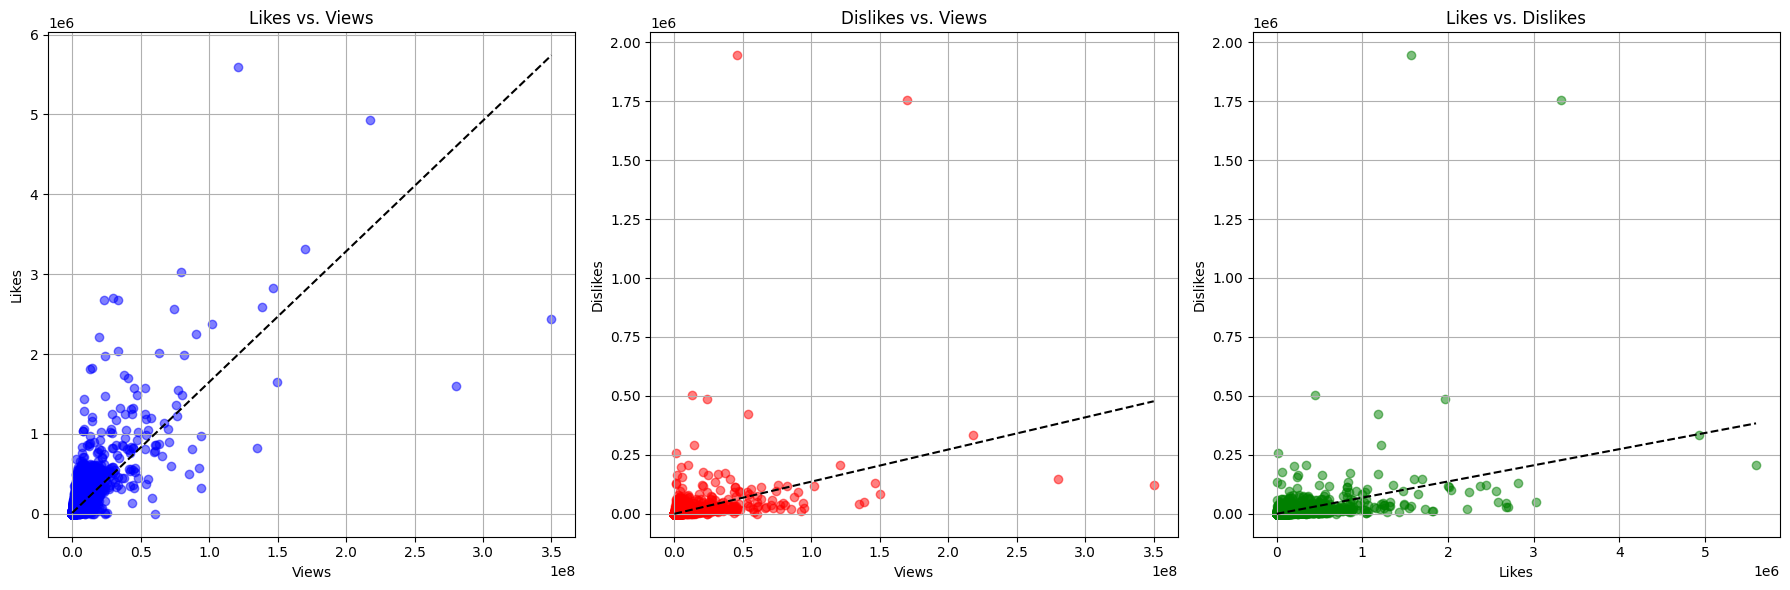

In [ ]:
likes = combined_df.likes
dislikes = combined_df.dislikes
views = combined_df.views


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(views, likes, color='blue', alpha=0.5)
plot_regression_line(views, likes, axs[0])
axs[0].set_title('Likes vs. Views')
axs[0].set_xlabel('Views')
axs[0].set_ylabel('Likes')
axs[0].grid(True)

# Scatter plot for dislikes vs. views
axs[1].scatter(views, dislikes, color='red', alpha=0.5)
plot_regression_line(views, dislikes, axs[1])
axs[1].set_title('Dislikes vs. Views')
axs[1].set_xlabel('Views')
axs[1].set_ylabel('Dislikes')
axs[1].grid(True)

# Scatter plot for likes vs. dislikes
axs[2].scatter(likes, dislikes, color='green', alpha=0.5)
plot_regression_line(likes, dislikes, axs[2])
axs[2].set_title('Likes vs. Dislikes')
axs[2].set_xlabel('Likes')
axs[2].set_ylabel('Dislikes')
axs[2].grid(True)

plt.tight_layout()
plt.show()

1.   The first plot shows the relationship between the number of likes a YouTube video receives and the number of views it receives. There appears to be a positive correlation, which means that as the number of views increases, the number of likes also tends to increase.

2. The second plot shows the relationship between the number of dislikes a YouTube video receives and the number of views it receives. There also appears to be a positive correlation in this plot, though it’s weaker than in the first plot. This means that as the number of views increases, the number of dislikes also tends to increase, but not as much as likes.

3. The third plot shows the relationship between the number of likes and the number of dislikes for YouTube videos. In this plot, it’s difficult to see a clear trend.


*It’s important to note that correlation doesn’t necessarily equal causation. Just because two variables appear to be related in a scatterplot doesn’t mean that one causes the other.*

### Data Cleaning and Preprocessing steps.

In [ ]:
# filter for entertainment category

entertainment_df = combined_df[combined_df['category_title'] == 'Entertainment']

In [ ]:
def detect_language(text):
    try:
        if text.strip():  # Check if the text is not empty
            return detect(text)
        else:
            return 'Unknown'
    except LangDetectException as e:
        # print(f"Error: {e}")
        return 'Unknown'

In [ ]:
entertainment_df['language'] = entertainment_df['title'].apply(detect_language)

In [ ]:
entertainment_df['language'].value_counts().head(3)

language
en    6466
de     546
ar     363
Name: count, dtype: int64

In [ ]:
!pip install -q wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
from wordcloud import WordCloud

In [ ]:
# get english text for wordcloud

wordcloud_text = entertainment_df[entertainment_df['language']=='en']['title'].str.cat(sep=' ')

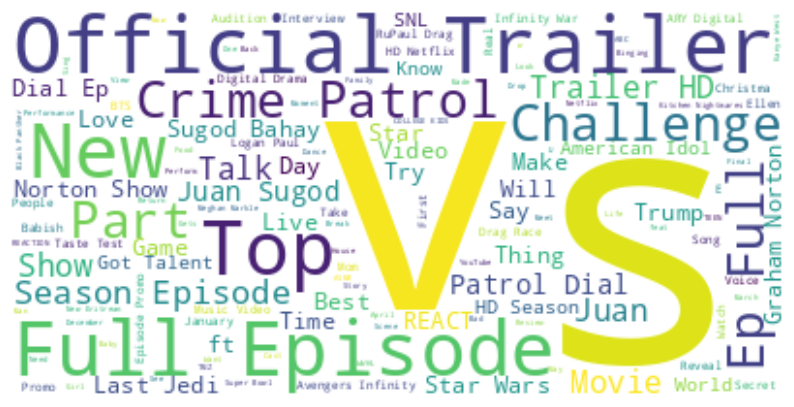

In [ ]:
# plot wordcloud

wordcloud = WordCloud(colormap='viridis',
                      background_color='white').generate(wordcloud_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Modelling

In [ ]:
entertainment = entertainment_df['title']
entertainment = entertainment.tolist()

In [ ]:
#remove punctuations and convert text to lowercase
def clean_text(text):
    text = ''.join(e for e in text if e not in string.punctuation).lower()

    text = text.encode('utf8').decode('ascii', 'ignore')
    return text

In [ ]:
corpus = [clean_text(e) for e in entertainment]

In [ ]:
corpus[:3]

['paul mccartney  pipes of peace',
 'mindy kalings daughter had the perfect reaction to entering oprahs house',
 'megan mullally didnt notice the interesting pattern with ellens roommates']

### Tokenization

In [ ]:
from tensorflow.keras.utils import to_categorical as ku

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from string import punctuation

In [ ]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Define the stopwords and punctuation
stopwords = list(STOP_WORDS)
punctuations = list(punctuation)

In [ ]:
def spacy_tokenizer(sentence):
    # Parse the sentence using the spaCy model
    mytokens = nlp(sentence)

    # Lemmatize and lowercase the tokens, remove stopwords and punctuation
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stopwords and word not in punctuations]

  #  print(mytokens)  # Debugging statement to check the tokens

    # Join the tokens back into a single string
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [ ]:
corpus = combined_df[combined_df.category_title == "Entertainment"]['title'].apply(spacy_tokenizer)

In [ ]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1

    ## convert data to sequence of tokens
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:10]

[[98, 3964],
 [98, 3964, 6018],
 [98, 3964, 6018, 2423],
 [2988, 2989],
 [2988, 2989, 647],
 [2988, 2989, 647, 734],
 [2988, 2989, 647, 734, 194],
 [2988, 2989, 647, 734, 194, 6019],
 [2988, 2989, 647, 734, 194, 6019, 495],
 [2988, 2989, 647, 734, 194, 6019, 495, 169]]

*Training Process:*

During training, the model is fed sequences of words and learns to predict the subsequent words in the sequence. The training process involves optimizing the model's parameters to minimize the prediction error.

### Post tokenization we need to pad the sequences

In [ ]:
def generate_padded_sequences(input_sequences, total_words):
  # Find the maximum sequence length
  max_sequence_len = max([len(x) for x in input_sequences])
  # Pad sequences to make them uniform in length
  input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
  # Separate predictors and labels
  predictors, label = input_sequences[:,:-1], input_sequences[:, -1]
  # Convert labels to categorical
  label = ku(label, num_classes=total_words)
  return predictors, label, max_sequence_len

In [ ]:
corpus = combined_df[combined_df.category_title == "Entertainment"]['title'].apply(spacy_tokenizer)

In [ ]:
input_sequences, total_words = get_sequence_of_tokens(corpus)
predictors, label, max_sequence_len = generate_padded_sequences(input_sequences, total_words)
print("Predictors shape:", predictors.shape)
print("Label shape:", label.shape)
print("Max sequence length:", max_sequence_len)
print("Tokenizer word index:", tokenizer.word_index)

Predictors shape: (61916, 41)
Label shape: (61916, 14682)
Max sequence length: 42
Tokenizer word index: {'episode': 1, '2018': 2, 'ep': 3, '2': 4, '2017': 5, '10': 6, 'season': 7, 'drama': 8, 'الحلقة': 9, 'official': 10, 'trailer': 11, 'hd': 12, 'tv': 13, 'new': 14, '12': 15, 'vs': 16, '3': 17, 'react': 18, 'مسلسل': 19, 'juan': 20, 'star': 21, 'challenge': 22, '1': 23, '18': 24, '5': 25, '4': 26, '11': 27, 'series': 28, 'video': 29, 'movie': 30, '【': 31, 'promo': 32, 'crime': 33, 'live': 34, '17': 35, 'patrol': 36, '01': 37, 'rani': 38, 'ka': 39, '《': 40, 'வாணி': 41, 'ராணி': 42, 'vaani': 43, '03': 44, 'digital': 45, '100': 46, 'trump': 47, 'war': 48, 'ary': 49, 'music': 50, 'know': 51, 'day': 52, '】': 53, 'try': 54, '6': 55, '02': 56, 'mehta': 57, 'ooltah': 58, 'chashmah': 59, 'ft': 60, 'taarak': 61, '8': 62, 'dial': 63, '15': 64, 'partie': 65, 'test': 66, 'love': 67, '14': 68, 'people': 69, '13': 70, 'january': 71, 'bahay': 72, 'march': 73, 'time': 74, 'voice': 75, 'sugod': 76, '16': 

### LSTM

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = predictors
y = label

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Training shape: (41483, 41)
Test shape: (20433, 41)


In [ ]:
# Train-Validation Split:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(f"Training shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("val shape:", X_val.shape)

Training shape: (33186, 41)
Test shape: (20433, 41)
val shape: (8297, 41)


In [ ]:
def create_model(max_sequence_len, total_words):
  input_len = max_sequence_len - 1
  model = Sequential()

  # Add Input Embedding Layer
  model.add(Embedding(total_words, 10, input_length=input_len))

  # Add Hidden Layer 1 — LSTM Layer
  model.add(LSTM(100))
  model.add(Dropout(0.1))

  # Add Output Layer
  model.add(Dense(total_words, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam')

  return model

In [ ]:
model = create_model(max_sequence_len, total_words)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_val, y_val))

Epoch 1/20
1038/1038 [==============================] - 36s 33ms/step - loss: 8.3593 - val_loss: 8.0574
Epoch 2/20
1038/1038 [==============================] - 34s 33ms/step - loss: 7.5369 - val_loss: 7.9148
Epoch 3/20
1038/1038 [==============================] - 34s 33ms/step - loss: 7.1109 - val_loss: 7.8558
Epoch 4/20
1038/1038 [==============================] - 34s 32ms/step - loss: 6.7119 - val_loss: 7.7733
Epoch 5/20
1038/1038 [==============================] - 34s 32ms/step - loss: 6.3414 - val_loss: 7.7941
Epoch 6/20
1038/1038 [==============================] - 34s 33ms/step - loss: 5.9888 - val_loss: 7.8500
Epoch 7/20
1038/1038 [==============================] - 34s 33ms/step - loss: 5.6658 - val_loss: 7.8802
Epoch 8/20
1038/1038 [==============================] - 34s 33ms/step - loss: 5.3574 - val_loss: 7.9438
Epoch 9/20
1038/1038 [==============================] - 34s 32ms/step - loss: 5.0756 - val_loss: 8.0199
Epoch 10/20
1038/1038 [==============================] - 34s 32m

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 41, 10)            146820    
                                                                 
 lstm_1 (LSTM)               (None, 100)               44400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 14682)             1482882   
                                                                 
Total params: 1674102 (6.39 MB)
Trainable params: 1674102 (6.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.evaluate(X_train, y_train)

NameError: name 'model' is not defined

In [ ]:
model.evaluate(X_test, y_test)

639/639 [==============================] - 7s 10ms/step - loss: 8.6773


8.677282333374023

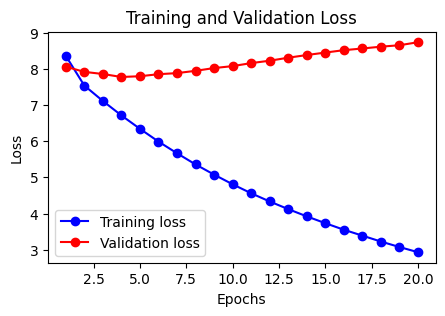

In [ ]:
# Extract loss values and plot
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(5, 3))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test

In [ ]:
token_list = tokenizer.texts_to_sequences(['spiderman'])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted = model.predict(token_list, verbose=0)

In [ ]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        # Tokenize the seed text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Pad the token list
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        # Predict probabilities for the next word
        predicted_probs = model.predict(token_list, verbose=0)
        # Get the index of the word with the highest probability
        predicted_index = np.argmax(predicted_probs)

        # Find the word corresponding to the predicted index
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break

        # Append the predicted word to the seed text
        seed_text += " " + output_word

    return seed_text.title()

In [ ]:
test_list = ['Star wars', 'Marvel', 'Dragon', 'Anime',  'Drama']

In [ ]:
for test_word in test_list:
  print(generate_text(test_word, 5, model, max_sequence_len))
  print("#"*25)

Star Wars Jedi Review Boy Seoul Idol
#########################
Marvel Studios Avengers Infinity War Official
#########################
Dragon Ball Super Bowl Commercial Tutorial
#########################
Anime Giant Angel Comedy Episode 146
#########################
Drama Cracker Ending Quang Tập 7
#########################


### Parameter tuning

In [ ]:
!pip install -q keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.2 MB/s eta 0:00:00


In [ ]:
import kerastuner as kt
from tensorflow.keras.optimizers import Adam

In [ ]:
def model_builder(hp):
  model = Sequential()
  model.add(Embedding(total_words, hp.Int('embedding_dim', min_value=10, max_value=100, step=10), input_length=max_sequence_len-1))
  model.add(LSTM(hp.Int('lstm_units', min_value=50, max_value=200, step=50), return_sequences=True))
  model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
  model.add(LSTM(hp.Int('lstm_units_2', min_value=50, max_value=200, step=50)))
  model.add(Dropout(hp.Float('dropout_rate_2', min_value=0.1, max_value=0.5, step=0.1)))
  model.add(Dense(total_words, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])))
  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='text_generation')

In [ ]:
# Adjusted search without validation split
tuner.search(predictors, label, epochs=20)

Trial 21 Complete [00h 01m 41s]
loss: 8.163689613342285

Best loss So Far: 4.63564395904541
Total elapsed time: 00h 31m 38s

Search: Running Trial #22

Value             |Best Value So Far |Hyperparameter
50                |70                |embedding_dim
100               |150               |lstm_units
0.5               |0.1               |dropout_rate
150               |100               |lstm_units_2
0.4               |0.1               |dropout_rate_2
1e-05             |0.001             |learning_rate
4                 |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round



In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of lstm units is {best_hps.get('lstm_units')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

model = tuner.hypermodel.build(best_hps)
model.fit(predictors, label, epochs=20, verbose=2)

Reloading Tuner from my_dir/text_generation/tuner0.json

The optimal number of lstm units is 150.
The optimal learning rate for the optimizer is 0.001.

Epoch 1/20
1/1 - 7s - loss: 2.3021 - 7s/epoch - 7s/step
Epoch 2/20
1/1 - 0s - loss: 2.2962 - 56ms/epoch - 56ms/step
Epoch 3/20
1/1 - 0s - loss: 2.2901 - 54ms/epoch - 54ms/step
Epoch 4/20
1/1 - 0s - loss: 2.2847 - 44ms/epoch - 44ms/step
Epoch 5/20
1/1 - 0s - loss: 2.2756 - 35ms/epoch - 35ms/step
Epoch 6/20
1/1 - 0s - loss: 2.2702 - 38ms/epoch - 38ms/step
Epoch 7/20
1/1 - 0s - loss: 2.2546 - 37ms/epoch - 37ms/step
Epoch 8/20
1/1 - 0s - loss: 2.2487 - 38ms/epoch - 38ms/step
Epoch 9/20
1/1 - 0s - loss: 2.2399 - 65ms/epoch - 65ms/step
Epoch 10/20
1/1 - 0s - loss: 2.2291 - 45ms/epoch - 45ms/step
Epoch 11/20
1/1 - 0s - loss: 2.2105 - 34ms/epoch - 34ms/step
Epoch 12/20
1/1 - 0s - loss: 2.1872 - 39ms/epoch - 39ms/step
Epoch 13/20
1/1 - 0s - loss: 2.1663 - 36ms/epoch - 36ms/step
Epoch 14/20
1/1 - 0s - loss: 2.1459 - 35ms/epoch - 35ms/step
Epoch 

*Challenges Faced During Parameter Tuning*

Computational Resources:
  - High Memory Usage: Training LSTM models on large datasets can be memory-intensive.
  - CPU/GPU Overload: Intensive computations can lead to CPU/GPU overloads, potentially causing system crashes.

Time-Consuming:
  - Long Training Times: Each model training iteration can be time-consuming, particularly with deep neural networks.
  - Multiple Iterations: Hyperparameter tuning requires numerous model training iterations, significantly increasing total computation time.

System Crashes:
  - Insufficient RAM: Running multiple experiments simultaneously can exhaust system memory.
  - Resource Contention: Competing processes might lead to resource contention, exacerbating the issue.

### Conclusion

In conclusion, the development of a title generation model using machine learning techniques presents a significant advancement in natural language processing and content creation.

Throughout this project, we have demonstrated the feasibility and effectiveness of leveraging machine learning, particularly LSTM neural networks, to generate engaging and relevant titles for YouTube videos or other types of content.

Overall, the title generation model represents a valuable contribution to the field of natural language processing, offering promising opportunities for enhancing content creation, marketing strategies, and user experiences across a wide range of industries and applications.

### Future Scope

The title generation model developed in this project opens up several avenues for future exploration and application:

* Integration into Content Platforms
  - The model can be integrated into various content creation platforms, such as blogging websites, video sharing platforms, and social media management tools, to assist users in generating engaging and relevant titles for their content.

* SEO and Marketing Tools:
  - By leveraging the model's capability to generate catchy titles, SEO professionals and marketers can use it to optimize content for search engines and social media platforms, thus improving visibility and engagement.

* Multimodal Content Generation:
  - Expanding the model to handle multimodal inputs, such as images, videos, and audio, can enable the generation of titles for various types of multimedia content, enriching the overall user experience.

* Natural Language Generation Research:
  - Further research and development in natural language generation techniques can advance the capabilities of title generation models, leading to more accurate, diverse, and context-aware title generation.

* User Experience Enhancement:
  - By automating the title generation process, the model can streamline content creation workflows, saving time and effort for content creators while ensuring the production of high-quality titles.

In [ ]:
!jupyter nbconvert --to html /content/drive/MyDrive/Colab_Notebooks/Final_Project.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab_Notebooks/Final_Project.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 2790815 bytes to /content/drive/MyDrive/Colab_Notebooks/Final_Project.html
